### Importing Libraries

In [1]:
import numpy as np
import os
import datetime

np.random.seed(30)
import random as rn
rn.seed(30)

from skimage.transform import resize, rescale
import imageio
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers 

### Initializing path & Importing datasets

In [2]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

In [3]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

import gc
gc.collect()

# training sequences = 663
# validation sequences = 100


51

### Generator Function

In [4]:
def generator(source_path, folder_list, batch_size, height, width, frames, augment=False):
    total_frames = 30
    num_images=frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels 

### Model accuracy Plot

In [5]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Code to save in each epochs

In [6]:
def call_back(name):   
    model_name = name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    callbacks_list = [checkpoint, LR]
    
    return callbacks_list

### Code to evaluate steps

In [7]:
def cal_steps() :
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    return steps_per_epoch, validation_steps

### Model params

In [8]:
batch_size = 32
num_epochs = 25
img_height = 120
img_width = 120
frames = 16

## Model CNN+RNN(Base) Model 1

In [9]:
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(64, (2, 2), padding='same'), input_shape=(frames, img_height,img_width, 3)))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(128, (2, 2), padding='same'))) 
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Flatten()))

model2.add(GRU(16,return_sequences=True))
model2.add(GRU(32))
model2.add(Dropout(0.5))
    
model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(5))
model2.add(Activation('softmax'))
optimiser = 'SGD'

model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 120, 120, 64)  832       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 120, 120, 64)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 128)   32896     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 60, 60, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 60, 60, 128)   5

In [10]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width,frames)

### Fit the model

In [11]:
callbacks_list = call_back('GR_RNN')
steps_per_epoch, validation_steps = cal_steps()
history = model2.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 2.0173 - categorical_accuracy: 0.2293
Epoch 00001: saving model to GR_RNN_2021-09-0812_59_28.376712/model-00001-2.01731-0.22926-1.60774-0.19000.h5
21/21 [==============================] - 96s 5s/step - loss: 2.0173 - categorical_accuracy: 0.2293 - val_loss: 1.6077 - val_categorical_accuracy: 0.1900
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.8981 - categorical_accuracy: 0.2066
Epoch 00002: saving model to GR_RNN_2021-09-0812_59_28.376712/model-00002-1.89811-0.20664-1.62169-0.19000.h5
21/21 [==============================] - 101s 5s/step - loss: 1.8981 - categorical_accuracy: 0.2066 - val_loss: 1.6217 - val_categorical_accuracy: 0.1900
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.8514 - categorical_accuracy: 0.2217
Epoch 00003: saving model to GR_RNN_2021-09-0812_59_28.376712/model-00003-1.85139-0.22172-1.63998-0.17000.h5
21/21 [==============================] - 95s 5s/

### Plotting

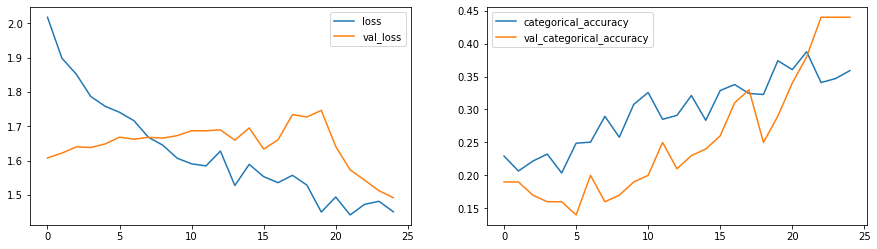

In [12]:
plot(history)

### Model params

In [8]:
batch_size = 32
num_epochs = 25
img_height = 120
img_width = 120
frames = 16

## Model CNN+RNN Model 2

In [9]:
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(frames, img_height,img_width, 3)))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
model2.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(256, (3, 3), padding='same'))) 
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Flatten()))

model2.add(GRU(32,return_sequences=True))
model2.add(GRU(64))
model2.add(Dropout(0.5))
    
model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(5))
model2.add(Activation('softmax'))
optimiser = 'SGD'

model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 120, 120, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 60, 60, 64)    2

In [10]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width,frames)

### Fit the model

In [11]:
callbacks_list = call_back('GR_RNN')
steps_per_epoch, validation_steps = cal_steps()
history = model2.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.9333 - categorical_accuracy: 0.2760
Epoch 00001: saving model to GR_RNN_2021-09-0718_19_12.413523/model-00001-1.93328-0.27602-1.60397-0.22000.h5
21/21 [==============================] - 77s 4s/step - loss: 1.9333 - categorical_accuracy: 0.2760 - val_loss: 1.6040 - val_categorical_accuracy: 0.2200
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.3891
Epoch 00002: saving model to GR_RNN_2021-09-0718_19_12.413523/model-00002-1.59650-0.38914-1.59675-0.17000.h5
21/21 [==============================] - 79s 4s/step - loss: 1.5965 - categorical_accuracy: 0.3891 - val_loss: 1.5967 - val_categorical_accuracy: 0.1700
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.4316 - categorical_accuracy: 0.4103
Epoch 00003: saving model to GR_RNN_2021-09-0718_19_12.413523/model-00003-1.43160-0.41026-1.62647-0.20000.h5
21/21 [==============================] - 77s 4s/s

### Plotting

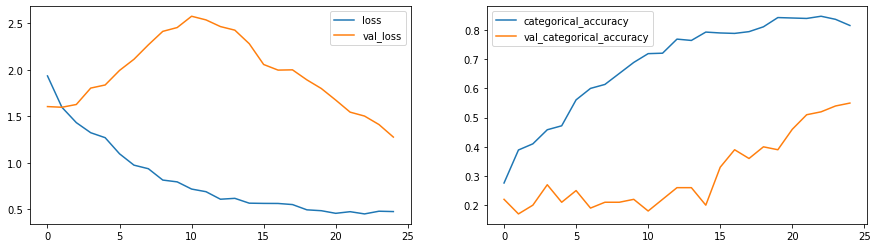

In [14]:
plot(history)

## CNN+RNN Model 3

### Model params

In [8]:
batch_size = 20
num_epochs = 25
img_height = 100
img_width = 100
frames = 18

### Model CNN+ RNN

In [9]:
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(64, (3, 3), padding='same'), input_shape=(frames, img_height,img_width, 3)))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
model2.add(TimeDistributed(Conv2D(256, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(512, (3, 3), padding='same'))) 
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Flatten()))

model2.add(GRU(64,return_sequences=True))
model2.add(GRU(128))
model2.add(Dropout(0.5))
    
model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Dense(5))
model2.add(Activation('softmax'))
optimiser = 'SGD'

model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 100, 100, 64)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 50, 50, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 50, 50, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 50, 50, 128)   5

In [10]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width, frames)

### Fit the Model

In [11]:
callbacks_list = call_back('GR_RNN')
steps_per_epoch, validation_steps = cal_steps()
history = model2.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9549 - categorical_accuracy: 0.2715
Epoch 00001: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00001-1.95487-0.27149-1.60879-0.25000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.9549 - categorical_accuracy: 0.2715 - val_loss: 1.6088 - val_categorical_accuracy: 0.2500
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.7610 - categorical_accuracy: 0.3273
Epoch 00002: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00002-1.76102-0.32730-1.69701-0.19000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.7610 - categorical_accuracy: 0.3273 - val_loss: 1.6970 - val_categorical_accuracy: 0.1900
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.6291 - categorical_accuracy: 0.3167
Epoch 00003: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00003-1.62915-0.31674-1.68452-0.22000.h5
34/34 [==============================] - 84s 2s/s

### Plotting

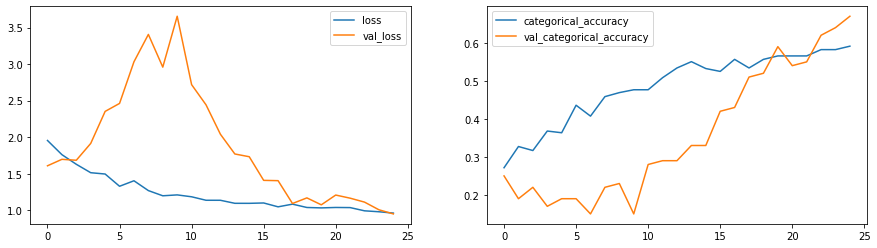

In [12]:
plot(history)

## CNN+RNN Model 4

### Model params

In [13]:
batch_size = 10
num_epochs = 50
img_height = 120
img_width = 120
frames = 15

### Model CNN+ RNN

In [14]:
model1 = Sequential()
model1.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(frames, img_height,img_width, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))

model1.add(Conv3D(256, (3, 3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model1.add(Conv3D(256, (3, 3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Dropout(0.20))

model1.add(Conv3D(512, (3, 3, 3), padding='same'))    
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(TimeDistributed(Flatten()))
model1.add(GRU(128, return_sequences=True))
model1.add(GRU(256))
model1.add(Dropout(0.5))
    
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Dense(5))
model1.add(Activation('softmax'))
optimiser = 'SGD'

model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 128) 10496     
_________________________________________________________________
activation_7 (Activation)    (None, 15, 120, 120, 128) 0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 128) 512       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 128)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 256)    884992    
_________________________________________________________________
activation_8 (Activation)    (None, 8, 60, 60, 256)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 256)   

In [15]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width, frames)

### Fit the Model

In [16]:
callbacks_list = call_back('GR_RNN')
steps_per_epoch, validation_steps = cal_steps()
history = model1.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.7973 - categorical_accuracy: 0.2685
Epoch 00001: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00001-1.79732-0.26848-1.61818-0.14000.h5
67/67 [==============================] - 70s 1s/step - loss: 1.7973 - categorical_accuracy: 0.2685 - val_loss: 1.6182 - val_categorical_accuracy: 0.1400
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.5775 - categorical_accuracy: 0.3590
Epoch 00002: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00002-1.57749-0.35897-1.65744-0.21000.h5
67/67 [==============================] - 70s 1s/step - loss: 1.5775 - categorical_accuracy: 0.3590 - val_loss: 1.6574 - val_categorical_accuracy: 0.2100
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.4160 - categorical_accuracy: 0.3967
Epoch 00003: saving model to GR_RNN_2021-09-0719_28_52.701378/model-00003-1.41603-0.39668-1.84845-0.21000.h5
67/67 [==============================] - 69s 1s/s

### Plotting

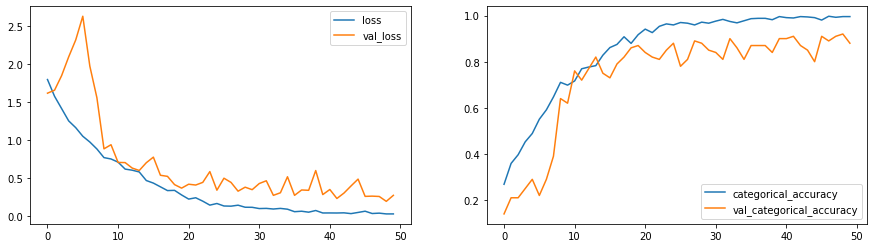

In [17]:
plot(history)

## CNN Model 5

### Model Params

In [13]:
batch_size = 32
num_epochs = 20
img_height = 120
img_width = 120
frames = 16

### Model CNN

In [14]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(frames, img_height,img_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'SGD'

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 60, 60, 32)    

In [15]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width, frames)

### Fit the model

In [16]:
callbacks_list = call_back('GR_CNN')
steps_per_epoch, validation_steps = cal_steps()
history = model.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4461 - categorical_accuracy: 0.4465
Epoch 00001: saving model to GR_CNN_2021-09-0812_59_28.376712/model-00001-1.44606-0.44646-1.59525-0.17000.h5
21/21 [==============================] - 77s 4s/step - loss: 1.4461 - categorical_accuracy: 0.4465 - val_loss: 1.5952 - val_categorical_accuracy: 0.1700
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.6616 - categorical_accuracy: 0.7406
Epoch 00002: saving model to GR_CNN_2021-09-0812_59_28.376712/model-00002-0.66164-0.74057-1.78005-0.19000.h5
21/21 [==============================] - 78s 4s/step - loss: 0.6616 - categorical_accuracy: 0.7406 - val_loss: 1.7801 - val_categorical_accuracy: 0.1900
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.3722 - categorical_accuracy: 0.8884
Epoch 00003: saving model to GR_CNN_2021-09-0812_59_28.376712/model-00003-0.37225-0.88839-2.33035-0.12000.h5
21/21 [==============================] - 77s 4s/s

### Plotting

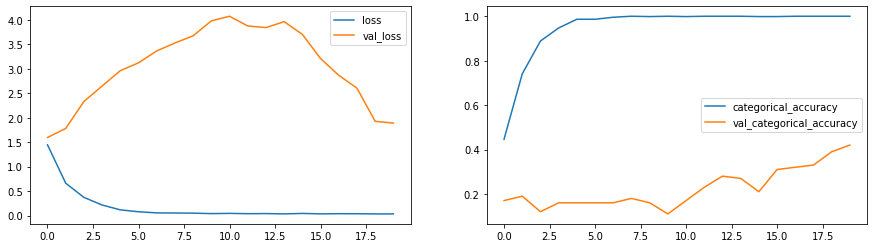

In [17]:
plot(history)

### CNN Model 6

### Model Params

In [8]:
batch_size = 32
num_epochs = 20
img_height = 120
img_width = 120
frames = 16

### Model CNN

In [9]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(frames, img_height,img_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))

model.add(Conv3D(128, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'SGD'

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [10]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width, frames)

### Fit the model

In [11]:
callbacks_list = call_back('GR_CNN')
steps_per_epoch, validation_steps = cal_steps()
history = model.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7541 - categorical_accuracy: 0.3635
Epoch 00001: saving model to GR_CNN_2021-09-0809_32_24.903899/model-00001-1.75410-0.36350-1.54930-0.25000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.7541 - categorical_accuracy: 0.3635 - val_loss: 1.5493 - val_categorical_accuracy: 0.2500
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2694 - categorical_accuracy: 0.5385
Epoch 00002: saving model to GR_CNN_2021-09-0809_32_24.903899/model-00002-1.26935-0.53846-1.57783-0.33000.h5
21/21 [==============================] - 78s 4s/step - loss: 1.2694 - categorical_accuracy: 0.5385 - val_loss: 1.5778 - val_categorical_accuracy: 0.3300
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.0883 - categorical_accuracy: 0.5716
Epoch 00003: saving model to GR_CNN_2021-09-0809_32_24.903899/model-00003-1.08826-0.57164-1.93243-0.25000.h5
21/21 [==============================] - 77s 4s/s

### Plotting

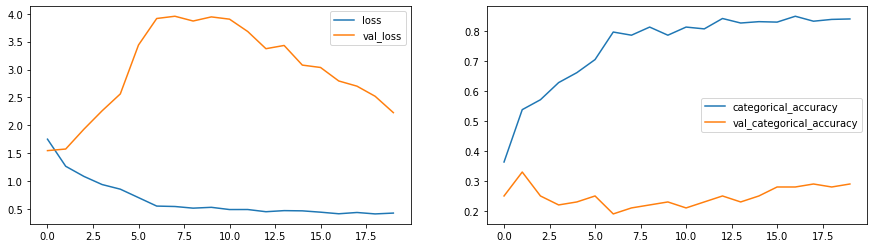

In [12]:
plot(history)

## CNN Model 7

### Model Params

In [8]:
batch_size = 10
num_epochs = 25
img_height = 120
img_width = 120
frames = 15

### Model CNN

In [9]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(frames, img_height,img_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))

model.add(Conv3D(512, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'SGD'

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 128) 10496     
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 128) 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 128) 512       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 128)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 256)    884992    
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 256)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 256)    1

In [10]:
train_generator = generator(train_path, train_doc, batch_size,img_height, img_width,frames)
val_generator = generator(val_path, val_doc, batch_size,img_height, img_width, frames)

### Fit the model

In [11]:
callbacks_list = call_back('GR_CNN')
steps_per_epoch, validation_steps = cal_steps()
history = model.fit(train_generator, 
                               steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6156 - categorical_accuracy: 0.3831
Epoch 00001: saving model to GR_CNN_2021-09-0810_09_42.223859/model-00001-1.61561-0.38311-1.92115-0.30000.h5
67/67 [==============================] - 73s 1s/step - loss: 1.6156 - categorical_accuracy: 0.3831 - val_loss: 1.9212 - val_categorical_accuracy: 0.3000
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2404 - categorical_accuracy: 0.5053
Epoch 00002: saving model to GR_CNN_2021-09-0810_09_42.223859/model-00002-1.24037-0.50528-1.93067-0.20000.h5
67/67 [==============================] - 72s 1s/step - loss: 1.2404 - categorical_accuracy: 0.5053 - val_loss: 1.9307 - val_categorical_accuracy: 0.2000
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9975 - categorical_accuracy: 0.5913
Epoch 00003: saving model to GR_CNN_2021-09-0810_09_42.223859/model-00003-0.99747-0.59125-2.77545-0.20000.h5
67/67 [==============================] - 72s 1s/s

### Plotting

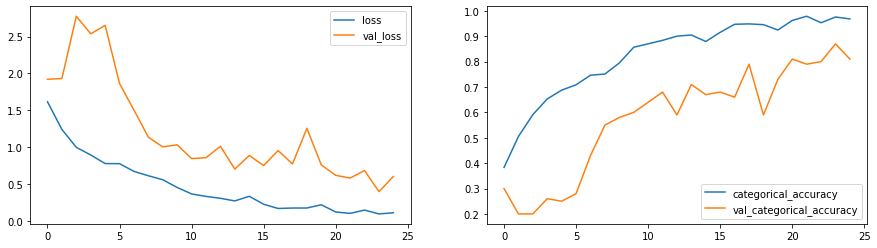

In [12]:
plot(history)